In [42]:
import numpy as np
import pandas as pd

import missingno
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from nltk.stem import RSLPStemmer
from nltk.sentiment.vader import SentimentIntensityAnalyzer


import re
from ftfy import fix_text
from num2words import num2words
from nltk.corpus import stopwords
import nltk
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import word_tokenize
nltk.download('stopwords')
nltk.download('wordnet')

import spacy
from spacy.lang.en.stop_words import STOP_WORDS
from spacy.lang.en import English

import sklearn

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [3]:
dataset_path = "olist_order_reviews_dataset.csv"
order_review = pd.read_csv(dataset_path)
order_review.head()

,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [4]:
order_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 7 columns):
 #   Column                   Non-Null Count  Dtype 
---  ------                   --------------  ----- 
 0   review_id                99224 non-null  object
 1   order_id                 99224 non-null  object
 2   review_score             99224 non-null  int64 
 3   review_comment_title     11568 non-null  object
 4   review_comment_message   40977 non-null  object
 5   review_creation_date     99224 non-null  object
 6   review_answer_timestamp  99224 non-null  object
dtypes: int64(1), object(6)
memory usage: 5.3+ MB


## Null value

In [5]:
order_review.isna().sum()

review_id                      0
order_id                       0
review_score                   0
review_comment_title       87656
review_comment_message     58247
review_creation_date           0
review_answer_timestamp        0
dtype: int64

In [6]:
order_review['review_comment_title'] = order_review['review_comment_title'].fillna("")
order_review['review_comment_message'] = order_review['review_comment_message'].fillna("")

order_review['have_review_message'] = order_review['review_comment_message'].apply(lambda x: 0 if x == '' else 1)

## Distribution of review score

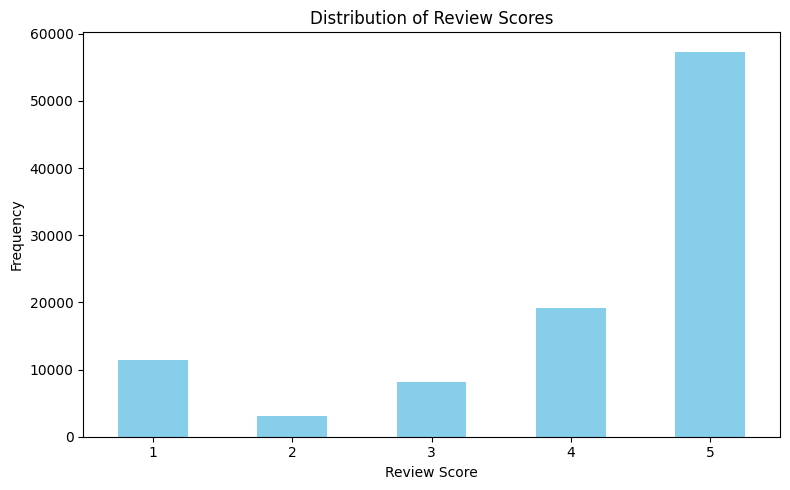

In [7]:
plt.figure(figsize=(8, 5))
order_review['review_score'].value_counts().sort_index().plot(kind='bar', color='skyblue')
plt.xlabel('Review Score')
plt.ylabel('Frequency')
plt.title('Distribution of Review Scores')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

## Text Analysis

In [8]:
order_review.review_comment_title.value_counts(dropna=False)

review_comment_title
                             87656
Recomendo                      423
recomendo                      345
Bom                            293
super recomendo                270
                             ...  
Luminaria sobrepor led 18        1
Não recebi.                      1
produto com lacre violado        1
Atraso Entrega                   1
Foto enganosa                    1
Name: count, Length: 4528, dtype: int64

In [9]:
order_review.review_comment_message.value_counts(dropna=False)

review_comment_message
                                                                                                                                                                                                       58247
Muito bom                                                                                                                                                                                                230
Bom                                                                                                                                                                                                      189
muito bom                                                                                                                                                                                                122
bom                                                                                                                                                          

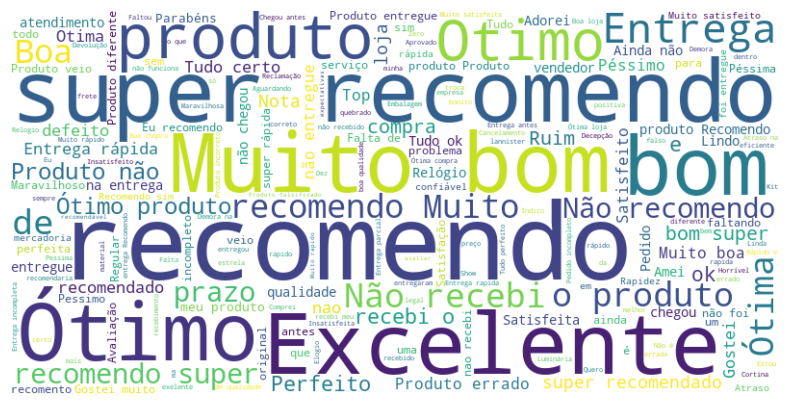

In [10]:
text_combined = ' '.join(order_review['review_comment_title'])

# Create the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

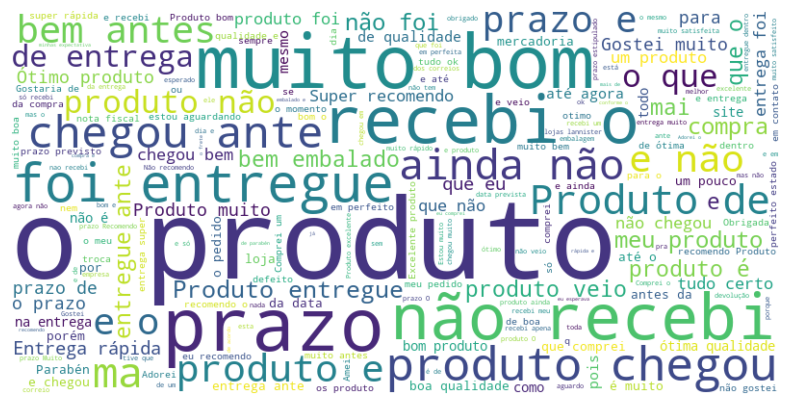

In [11]:
text_combined = ' '.join(order_review['review_comment_message'])

# Create the word cloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text_combined)

# Display the word cloud using matplotlib
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

## Clean text data

Breakline and Carriage Return

In [12]:
def remove_breakline_carriage_return(df, column_name):
    """
    Remove breaklines and carriage returns from a column in a pandas DataFrame.

    Args:
    df (pandas.DataFrame): The DataFrame containing the column.
    column_name (str): The name of the column from which to remove breaklines and carriage returns.

    Returns:
    pandas.DataFrame: The DataFrame with breaklines and carriage returns removed from the specified column.
    """
    # Define a lambda function to remove breaklines and carriage returns
    remove_func = lambda x: re.sub(r'[\n\r]', '', x) if isinstance(x, str) else x
    
    # Apply the lambda function to the specified column
    df[column_name] = df[column_name].apply(remove_func)
    
    return df

In [13]:
order_review = remove_breakline_carriage_return(order_review, 'review_comment_message')

In [14]:
order_review.review_comment_message.value_counts(dropna=False)

review_comment_message
                                                                                         58265
Muito bom                                                                                  238
Bom                                                                                        196
muito bom                                                                                  132
bom                                                                                        109
                                                                                         ...  
Produto um pouço maior do que na imagem, mas ficou legal.                                    1
não recebi minha encomenda ainda                                                             1
PRODUTO FOI ENTREGUE VIA CORREIOSANTES DO PRAZO PREVISTO.                                    1
Devido incompatibilidade vou devolver, ótimo produto!                                        1
meu produto chegou e ja ten

Sites and Hiperlinks

In [15]:
def re_hiperlinks(text):
    """
    Args:
    ----------
    text: string object with text content to be prepared [type: str]
    """
    # Applying regex
    pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'
    return re.sub(pattern, ' link ', text)


<>:8: SyntaxWarning: invalid escape sequence '\('
<>:8: SyntaxWarning: invalid escape sequence '\('
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18208\3122173406.py:8: SyntaxWarning: invalid escape sequence '\('
  pattern = 'http[s]?://(?:[a-zA-Z]|[0-9]|[$-_@.&+]|[!*\(\),]|(?:%[0-9a-fA-F][0-9a-fA-F]))+'


In [16]:
order_review['review_comment_message'] = order_review['review_comment_message'].apply(re_hiperlinks)

date

In [17]:
def re_dates(text):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'
    return re.sub(pattern, ' date ', text)

<>:9: SyntaxWarning: invalid escape sequence '\/'
<>:9: SyntaxWarning: invalid escape sequence '\/'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18208\1619113387.py:9: SyntaxWarning: invalid escape sequence '\/'
  pattern = '([0-2][0-9]|(3)[0-1])(\/|\.)(((0)[0-9])|((1)[0-2]))(\/|\.)\d{2,4}'


In [18]:
order_review['review_comment_message'] = order_review['review_comment_message'].apply(re_dates)

money

In [19]:
def re_money(text):
    """
    Args:
    ----------
    text_list: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'
    return re.sub(pattern, ' dinheiro ', text)

<>:9: SyntaxWarning: invalid escape sequence '\$'
<>:9: SyntaxWarning: invalid escape sequence '\$'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18208\1427430259.py:9: SyntaxWarning: invalid escape sequence '\$'
  pattern = '[R]{0,1}\$[ ]{0,}\d+(,|\.)\d+'


In [20]:
order_review['review_comment_message'] = order_review['review_comment_message'].apply(re_money)

number

In [21]:
def re_numbers(text):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return re.sub('[0-9]+', ' numero ', text)

In [22]:
order_review['review_comment_message'] = order_review['review_comment_message'].apply(re_numbers)

negation

In [23]:
def re_negation(text):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return re.sub('([nN][ãÃaA][oO]|[ñÑ]| [nN] )', ' negação ', text)

In [24]:
order_review['review_comment_message'] = order_review['review_comment_message'].apply(re_negation)

special character

In [25]:
def re_special_chars(text):
    """
    Args:
    ----------
    text_series: list object with text content to be prepared [type: list]
    """
    
    # Applying regex
    return re.sub('\W', ' ', text)

<>:9: SyntaxWarning: invalid escape sequence '\W'
<>:9: SyntaxWarning: invalid escape sequence '\W'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18208\3423462199.py:9: SyntaxWarning: invalid escape sequence '\W'
  return re.sub('\W', ' ', text)


In [26]:
order_review['review_comment_message'] = order_review['review_comment_message'].apply(re_special_chars)

additional space

In [27]:
def re_whitespaces(text):
    """
    Args:
    ----------
    text: string object with text content to be prepared [type: str]
    """
    # Applying regex
    text = re.sub('\s+', ' ', text)
    text = re.sub('[ \t]+$', '', text)
    return text

<>:8: SyntaxWarning: invalid escape sequence '\s'
<>:8: SyntaxWarning: invalid escape sequence '\s'
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18208\3544860311.py:8: SyntaxWarning: invalid escape sequence '\s'
  text = re.sub('\s+', ' ', text)


In [28]:
order_review['review_comment_message'] = order_review['review_comment_message'].apply(re_whitespaces)

Stopwords

In [29]:
# Examples of some portuguese stopwords
pt_stopwords = stopwords.words('portuguese')
print(f'Total portuguese stopwords in the nltk.corpous module: {len(pt_stopwords)}')
pt_stopwords[:10]

Total portuguese stopwords in the nltk.corpous module: 207


['a',
 'à',
 'ao',
 'aos',
 'aquela',
 'aquelas',
 'aquele',
 'aqueles',
 'aquilo',
 'as']

In [30]:
def stopwords_removal(text, cached_stopwords=stopwords.words('portuguese')):
    """
    Remove stopwords and convert text to lowercase.

    Args:
    text: string object containing the text.
    cached_stopwords: list of stopwords to be removed (default: Portuguese stopwords).

    Returns:
    Cleaned text without stopwords and converted to lowercase.
    """
    cleaned_text = ' '.join(word.lower() for word in text.split() if word.lower() not in cached_stopwords)
    return cleaned_text

In [31]:
order_review['review_comment_message'] = order_review['review_comment_message'].apply(stopwords_removal)

stemming

In [32]:
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

# Initialize the PorterStemmer
stemmer = RSLPStemmer()

# Define the function to perform stemming
def stem_text(text):
    # Tokenize the text into words
    words = word_tokenize(text)
    # Stem each word and join them back into a string
    stemmed_words = [stemmer.stem(word) for word in words]
    return ' '.join(stemmed_words)

In [33]:
order_review['review_comment_message'] = order_review['review_comment_message'].apply(stem_text)

## Get the sentiment score

In [34]:
from textblob import TextBlob

def calculate_sentiment(text):
    blob = TextBlob(text)
    sentiment_score = blob.sentiment.polarity  # polarity ranges from -1 (negative) to 1 (positive)
    return sentiment_score

# Apply the calculate_sentiment function to the 'text_column' in the DataFrame
order_review['sentiment_score'] = order_review['review_comment_message'].apply(calculate_sentiment)

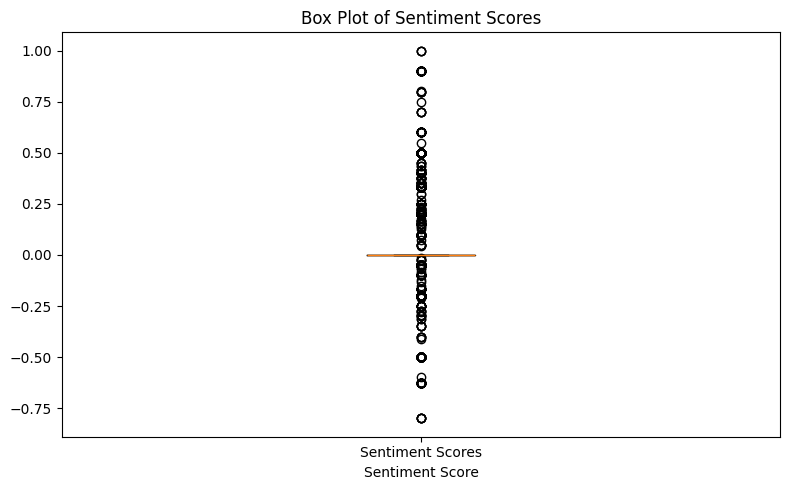

In [35]:
plt.figure(figsize=(8, 5))
plt.boxplot(order_review['sentiment_score'])
plt.xlabel('Sentiment Score')
plt.title('Box Plot of Sentiment Scores')
plt.xticks([1], ['Sentiment Scores'])
plt.tight_layout()
plt.show()

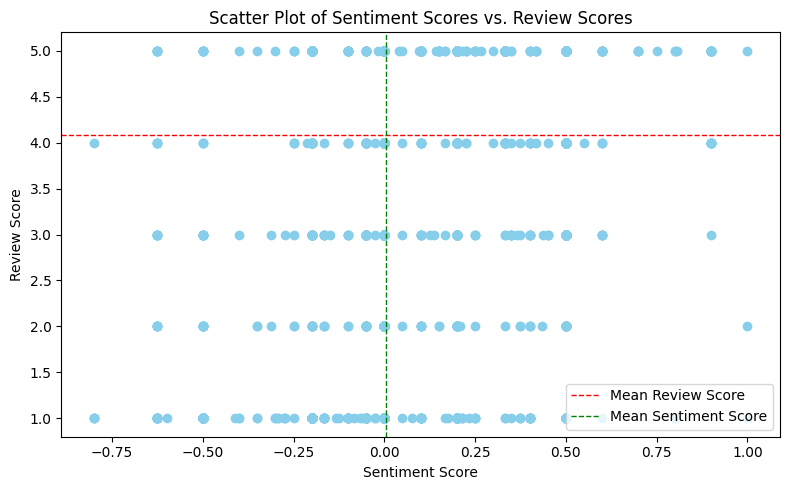

In [36]:
plt.figure(figsize=(8, 5))
plt.scatter(order_review['sentiment_score'], order_review['review_score'], color='skyblue')
plt.xlabel('Sentiment Score')
plt.ylabel('Review Score')
plt.title('Scatter Plot of Sentiment Scores vs. Review Scores')
plt.axhline(order_review['review_score'].mean(), color='red', linestyle='--', linewidth=1, label='Mean Review Score')
plt.axvline(order_review['sentiment_score'].mean(), color='green', linestyle='--', linewidth=1, label='Mean Sentiment Score')
plt.legend()
plt.tight_layout()
plt.show()

## Try message length

In [37]:
order_review['message_length'] = order_review['review_comment_message'].apply(len)

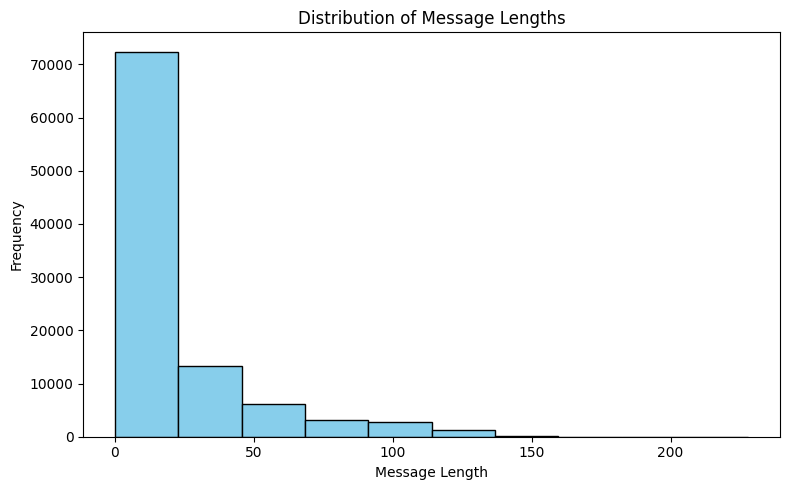

In [38]:
# Visualize the distribution of message lengths using a histogram
plt.figure(figsize=(8, 5))
plt.hist(order_review['message_length'], bins=10, color='skyblue', edgecolor='black')
plt.xlabel('Message Length')
plt.ylabel('Frequency')
plt.title('Distribution of Message Lengths')
plt.tight_layout()
plt.show()

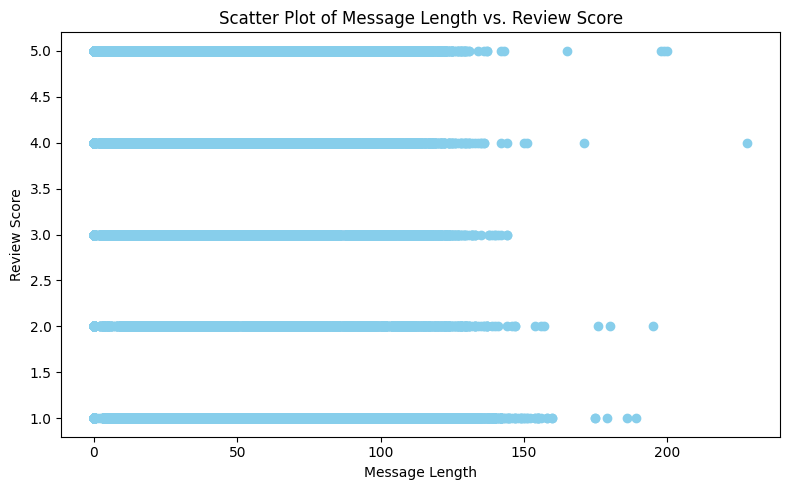

In [39]:
plt.figure(figsize=(8, 5))
plt.scatter(order_review['message_length'], order_review['review_score'], color='skyblue')
plt.xlabel('Message Length')
plt.ylabel('Review Score')
plt.title('Scatter Plot of Message Length vs. Review Score')
plt.tight_layout()
plt.show()

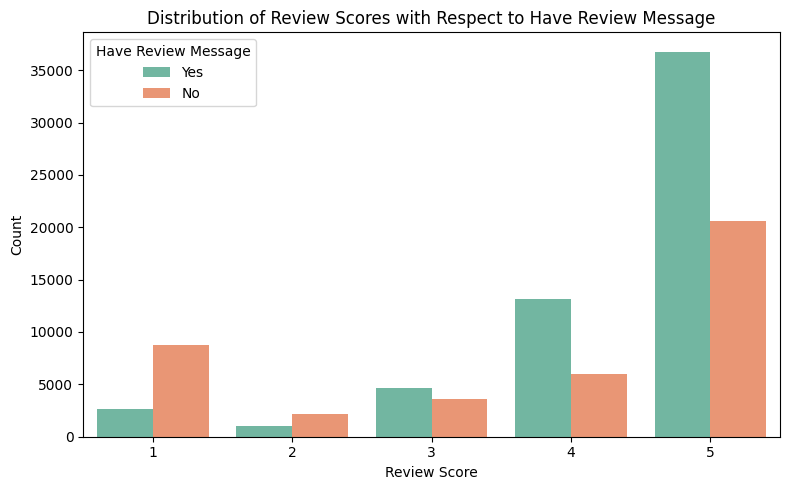

In [40]:
plt.figure(figsize=(8, 5))
sns.countplot(x='review_score', hue='have_review_message', data=order_review, palette='Set2')
plt.xlabel('Review Score')
plt.ylabel('Count')
plt.title('Distribution of Review Scores with Respect to Have Review Message')
plt.legend(title='Have Review Message', labels=['Yes', 'No'])
plt.tight_layout()
plt.show()

#### Higher score tend to have review message

## Because the first sentiment score does not seem to provide good information, try another one

In [50]:
nltk.download('vader_lexicon')

z = order_review.iloc[5]['review_comment_message']
dfrev = pd.DataFrame([['example', {'neg' : 0.0, 'neu' : 1.0, 'pos': 0.0}] , ['example', {'neg' : 0.0, 'neu' : 1.0, 'pos': 0.0}]]
                     , columns = ['review', 'polarity-scores'])
testarr = []
# Vader Sentiment Intensity Analyzer 
sia = SentimentIntensityAnalyzer()
sia.polarity_scores("Wow, NLTK is really shitty!")

order_review['polarity_scores'] = order_review['review_comment_message'].apply(lambda x: sia.polarity_scores(str(x)))
testdb = order_review[['review_score', 'review_comment_message', 'polarity_scores']]
order_review['compound_sentiment_score'] = testdb['polarity_scores'].apply(lambda score_dict: score_dict['compound'])
testdb['compound'] = testdb['polarity_scores'].apply(lambda score_dict: score_dict['compound'])

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_18208\4190887905.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  testdb['compound'] = testdb['polarity_scores'].apply(lambda score_dict: score_dict['compound'])


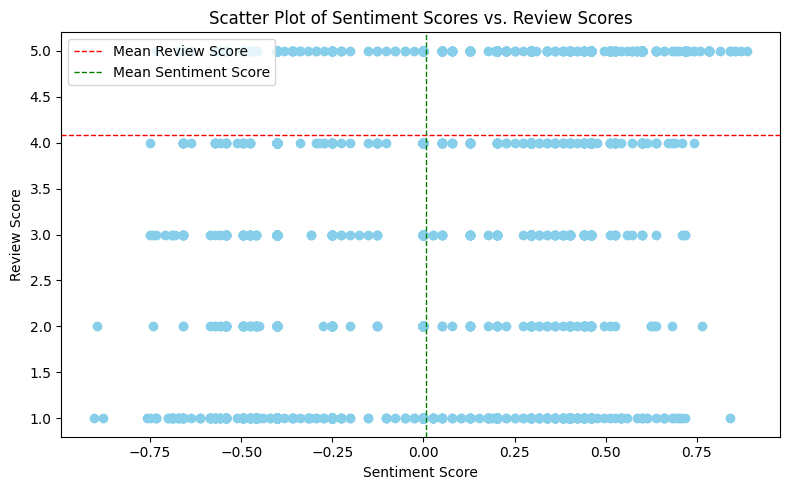

In [47]:
plt.figure(figsize=(8, 5))
plt.scatter(order_review['compound_sentiment_score'], order_review['review_score'], color='skyblue')
plt.xlabel('Sentiment Score')
plt.ylabel('Review Score')
plt.title('Scatter Plot of Sentiment Scores vs. Review Scores')
plt.axhline(order_review['review_score'].mean(), color='red', linestyle='--', linewidth=1, label='Mean Review Score')
plt.axvline(order_review['compound_sentiment_score'].mean(), color='green', linestyle='--', linewidth=1, label='Mean Sentiment Score')
plt.legend()
plt.tight_layout()
plt.show()

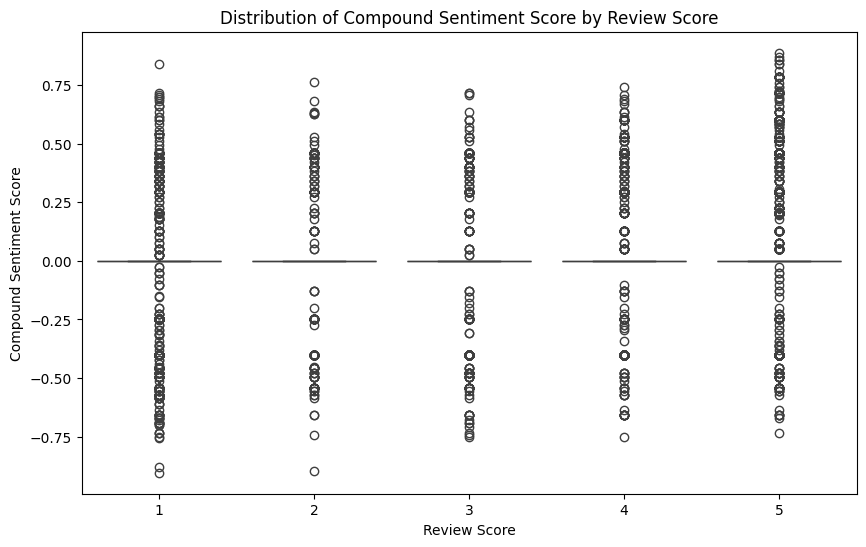

In [48]:
plt.figure(figsize=(10, 6))
sns.boxplot(x='review_score', y='compound_sentiment_score', data=order_review)
plt.title('Distribution of Compound Sentiment Score by Review Score')
plt.xlabel('Review Score')
plt.ylabel('Compound Sentiment Score')
plt.show()

#### Again, no clear pattern can be found.

## Maybe we look into what words contribute to negative and positive score.

#### Top 10 best reviews

In [45]:
y = pd.DataFrame(testdb.sort_values(by= 'compound', ascending = False).head(10)[['review_comment_message', 'compound']])
y.head(10)

,review_comment_message,compound
73301,super expect produt excel qual adore sempr ent...,0.8885
60282,grand satisf compr produt excel qual super exp...,0.8720
4035,excel bonit ajust facil braç neg grand tamanh ...,0.8555
39147,atend expect bel jog xadr excel acab peç tabul...,0.8555
55695,serviç excel produt excel praz excel loj fant,0.8402
53782,luz lantern fort ideal pedal noit possu numer ...,0.8402
47782,produt nizzi amor hidrat avanç numer g lacqu d...,0.8402
89857,produt boa qual acab preç send vend apes neg g...,0.8126
20725,produt cheg rápid super expect excel,0.7845
84729,atend excel extrem rápid produt ótim qual supe...,0.7845


#### Top 10 worst review

In [51]:
x = pd.DataFrame(testdb.sort_values(by= 'compound', ascending = True).head(10)[['review_comment_message', 'compound']])
x.head(10)

,review_comment_message,compound
18278,lament cancel ped err comput fiz ped dua vez q...,-0.9042
63334,compr numer rob pag vei so numer rob numer uni...,-0.8957
58249,neg receb produt relógi feminin puls hell kitt...,-0.8807
46004,temp soment hoj receb mens seguint inform boa ...,-0.7579
65562,sit difícil us neg atualiz fic dand problem to...,-0.7506
89869,vei tud cert ant dat prev apen numer pequen pe...,-0.7506
65187,quadr mal produz neg encost pared fat centr ar...,-0.7506
85812,imagin mad pouc gross ach fin lind,-0.7430
1278,depend poss avali resolv problem po compr nume...,-0.7430
67382,produt vei defeit tent efetu troc sistem diz p...,-0.7351


#### most popular words in NEGATIVE reviews

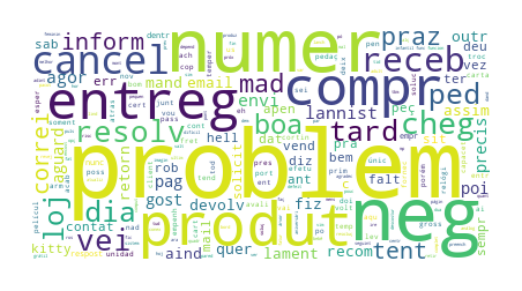

In [53]:
fig, ax = plt.subplots(figsize=(3,1), dpi=300)
bad_reviews = pd.DataFrame(testdb.sort_values(by= 'compound', ascending = True).head(50)[['review_comment_message', 'compound']])
text = " ".join(review for review in bad_reviews.review_comment_message)
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white').generate(text)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()

#### most popular words in POSITIVE reviews

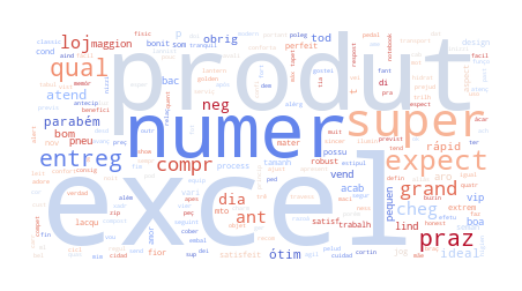

In [54]:
fig, ax = plt.subplots(figsize=(3,1), dpi=300)
good_reviews = pd.DataFrame(testdb.sort_values(by= 'compound', ascending = False).head(50)[['review_comment_message', 'compound']])
text = " ".join(review for review in good_reviews.review_comment_message)
# Creating word_cloud with text as argument in .generate() method
word_cloud = WordCloud(collocations = False, background_color = 'white', colormap = 'coolwarm').generate(text)
# Display the generated Word Cloud
plt.imshow(word_cloud, interpolation='bilinear')
plt.axis("off")
plt.show()